In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report

import catboost as cb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import time

In [2]:
data = pd.read_csv('data/medical_examination.csv')

In [3]:
data["age"] = data["age"].apply(lambda x: round(x/365, 1))

In [4]:
data["sex"].loc[data["sex"] == 3] = data["sex"].median()

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
data.head()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.4,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.4,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.7,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.3,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.9,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
data["hi_lo"] = data["ap_hi"]/data["ap_lo"]

In [7]:
data["weight_height"] = data["weight"]/data["height"]

In [8]:
data["cholesterol_height"] = data["cholesterol"]/data["weight"]

In [9]:
data["cholesterol_age"] = data["cholesterol"]/data["age"]

In [19]:
age_frec = dict(data["age"].value_counts(normalize=True))
age_frec

{56.0: 0.011042857142857142,
 54.0: 0.010914285714285715,
 55.9: 0.010585714285714285,
 56.1: 0.010542857142857142,
 58.0: 0.010314285714285715,
 60.0: 0.010014285714285715,
 57.9: 0.01,
 50.0: 0.009985714285714285,
 54.1: 0.009871428571428571,
 53.9: 0.009842857142857143,
 53.8: 0.009757142857142857,
 54.2: 0.009557142857142858,
 58.1: 0.009342857142857142,
 60.1: 0.009285714285714286,
 60.2: 0.009257142857142858,
 55.8: 0.009185714285714285,
 59.9: 0.009142857142857144,
 56.2: 0.009114285714285714,
 58.2: 0.009042857142857142,
 52.0: 0.009042857142857142,
 52.1: 0.009042857142857142,
 52.2: 0.008971428571428571,
 57.8: 0.008942857142857143,
 50.1: 0.008757142857142857,
 51.9: 0.008657142857142856,
 49.9: 0.008657142857142856,
 49.8: 0.008657142857142856,
 59.8: 0.008628571428571428,
 50.2: 0.008557142857142857,
 54.3: 0.008485714285714286,
 53.7: 0.00842857142857143,
 55.7: 0.008271428571428572,
 59.7: 0.008085714285714286,
 51.7: 0.007814285714285715,
 57.7: 0.0078,
 51.8: 0.0077857

In [21]:
data["age_frec"] = data["age"].map(age_frec)

In [40]:
# CatBoost
def catboost_base(x, x_val, y, y_val):
    cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.001,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": False,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
    }

    model = cb.CatBoostClassifier(**cb_params)
    model.fit(x, y,
        )
    y_pred = model.predict(x_val)
    ra = roc_auc_score(y_val, y_pred)
    print("roc_auc_score: ",ra)
    print("confusion_matrix: ",confusion_matrix(y_val, y_pred))
    print("accuracy_score: ",accuracy_score(y_val, y_pred))
    return model


In [36]:
def train_split(x, y, Random_State= 27):
    """x: dataframe, y: name target name"""
    x_train, x_valid, y_train, y_valid = train_test_split(x.drop(y, axis=1), x[y], test_size = 0.2, random_state=Random_State)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state=Random_State)
    print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape)
    return x_train, x_valid, y_train, y_valid, x_test, y_test

In [37]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(data, "cardio")

(44800, 17) (14000, 17) (44800,) (14000,) (11200, 17) (11200,)


In [41]:
model = catboost_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.7315620261199731
confusion_matrix:  [[5517 1467]
 [2293 4723]]
accuracy_score:  0.7314285714285714


In [42]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,ap_hi,48.431923
1,age,19.564097
2,cholesterol,9.800133
3,cholesterol_age,7.344621
4,ap_lo,4.460652
5,weight_height,2.767168
6,weight,2.005973
7,active,1.403023
8,gluc,1.295466
9,cholesterol_height,1.261902


In [43]:
def corr(data, target):
    correlation = data.corr()
    corr_with_target = correlation[target].sort_values(ascending = False)
    print(corr_with_target)
    fig, axes = plt.subplots(figsize = (14,12))
    plt.title("Correlation of Numeric Features with target", y=1, size=16)
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

cardio                1.000000
age                   0.238137
cholesterol           0.221147
weight_height         0.189278
weight                0.181660
cholesterol_age       0.163473
cholesterol_height    0.148029
gluc                  0.089307
ap_lo                 0.065719
age_frec              0.063224
ap_hi                 0.054475
hi_lo                 0.011908
sex                   0.008140
id                    0.003799
alco                 -0.007330
height               -0.010821
smoke                -0.015486
active               -0.035653
Name: cardio, dtype: float64


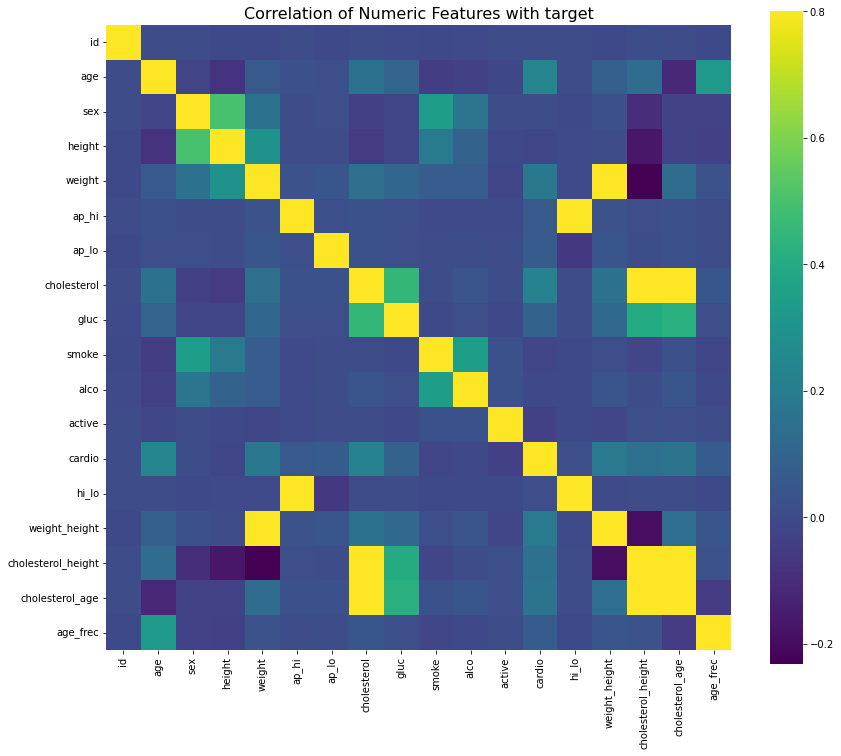

In [44]:
corr(data, "cardio")

In [47]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(data, "cardio")

(44800, 16) (14000, 16) (44800,) (14000,) (11200, 16) (11200,)


In [48]:
model = catboost_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.7313488821492617
confusion_matrix:  [[5519 1465]
 [2298 4718]]
accuracy_score:  0.7312142857142857
